In [1]:
!curl -L https://www.dropbox.com/s/i34l0ul6qs1nwk7/test_points.csv?dl=0 -o test_points.csv
!curl -L https://www.dropbox.com/s/jh0hbzv8aygx0v1/sampleSubmission.csv?dl=0 -o sampleSubmission.csv
!curl -L https://www.dropbox.com/s/wg4kb353cq668wb/hack_utils.py?dl=0 -o hack_utils.py
!curl -L https://www.dropbox.com/s/m6zd1isw6ni0v5q/data.zip?dl=0 -o data.zip
!unzip data.zip
!mv test_points.csv data/test
!rm data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/test/images/ad376cc7c6d3839772d1eec8bd162b41.jpg  
  inflating: data/test/images/d24b53c187b578cbf9afb269cc40150d.jpg  
  inflating: data/test/images/c5552f8044a7830ad9ed2f70cc16c1a9.jpg  
  inflating: data/test/images/2979a5aa1c1bca7dc88dda407d69d966.jpg  
  inflating: data/test/images/9c0b05b8dfebc4271fa6eb778a68d8a1.jpg  
  inflating: data/test/images/b01e4a99396b3f24805175ce6812c955.jpg  
  inflating: data/test/images/de00f55dfba5df0167c005fa61c981ef.jpg  
  inflating: data/test/images/953fe3a0590ceeb377e721c8fea650a2.jpg  
  inflating: data/test/images/896f9e28ceb442444f197d165201796d.jpg  
  inflating: data/test/images/efd44352c84d1c109da58de07b870de8.jpg  
  inflating: data/test/images/616c0079347d99433b13ada17b26879a.jpg  
  inflating: data/test/images/162d7de334e9df7fe72288c6697daf49.jpg  
  inflating: data/test/images/e1ced8f7aabf6bf1c6c81d7eb14cea86.jpg  
  inflating: data/test/images/8e4ac574eec354717a5349

In [0]:
import os
tr_names = os.listdir('data/train/images')
test_names = os.listdir('data/test/images')
len(tr_names), len(test_names)

(393930, 99819)

In [0]:
import pandas as pd
landmarks = pd.read_csv('data/train/landmarks.csv', sep='\t', nrows=1000)

In [0]:
train_p = landmarks[landmarks.file_name.isin(tr_names)]
test_p = landmarks[landmarks.file_name.isin(test_names)]

In [0]:
train_points.head()

file_name  Point_0_X  ...  Point_970_X  Point_970_Y
0  07c5e48d938e8d82c0f10973d66183f3.jpg        162  ...          191          166
1  1daf2e7328d121ec280c08f62926e2f9.jpg        136  ...          191          156
2  98d5186671bbcb31a79a16878a57de77.jpg        113  ...          143          120
3  12434863c3a9d9b8b3b0889a4d08d340.jpg        119  ...          182          149
4  28e70684d6e2d6d75a6d3a973e4d4d93.jpg         89  ...          162          202

[5 rows x 1943 columns]

In [0]:
test_points = pd.read_csv('data/test/test_points.csv', sep='\t', nrows=1000)
test_points.head()

file_name                                   point_index_list
0  c59b2834147079f3e34627f1e75656b1.jpg  [742, 385, 583, 758, 132, 634, 779, 219, 750, ...
1  85629eb20fdbbb98d0ee20ed9f3ba233.jpg  [456, 549, 339, 804, 143, 241, 121, 291, 835, ...
2  4df0124462ce32e0e8dd5d96a7d6496d.jpg  [343, 907, 662, 470, 551, 1, 15, 144, 126, 557...
3  fca085b03b834d9d94170e8f1453276e.jpg  [916, 842, 715, 351, 147, 808, 893, 785, 591, ...
4  67b598c8621b1f7135dfbc1c47fe2893.jpg  [818, 186, 469, 337, 768, 358, 887, 207, 145, ...

Модель

In [0]:
from torchvision import transforms
from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from argparse import ArgumentParser
from hack_utils import ThousandLandmarksDataset
import os
from torch.utils import data
import pickle
import sys
import numpy as np
import torch.nn as nn
import tqdm
from hack_utils import restore_landmarks_batch, create_submission

import torch
import torchvision
from hack_utils import NUM_PTS, CROP_SIZE
import torchvision.models as models

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
train_transforms = transforms.Compose([
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
    ])

In [4]:
def parse_arguments():
    parser = ArgumentParser(__doc__)
    parser.add_argument("--name", "-n", help="Experiment name (for saving checkpoints and submits).",
                        default="baseline_1")
    parser.add_argument("--data", "-d", help="Path to dir with target images & landmarks.", 
                        default='data/')
    parser.add_argument("--batch-size", "-b", default=512, type=int)  # 512 is OK for resnet18 finetune @ 6Gb of VRAM
    parser.add_argument("--epochs", "-e", default=22, type=int)
    parser.add_argument("--learning-rate", "-lr", default=7e-3, type=float) #1e-3
    parser.add_argument("--gpu", action="store_true", default=True)
    return parser.parse_known_args()[0]
args = parse_arguments()
args

Namespace(batch_size=512, data='data/', epochs=22, gpu=True, learning_rate=0.007, name='baseline_1')

In [5]:
%%time
print("Reading data...")
train_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                    shuffle=True, drop_last=True)
val_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                  shuffle=False, drop_last=False)

Reading data...
CPU times: user 9min 35s, sys: 53.9 s, total: 10min 29s
Wall time: 10min 35s


In [6]:
print("Creating model...")
device = torch.device("cuda: 0")

# load a model pre-trained pre-trained on COCO
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)
model.to(device)

Creating model...


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
import torch.optim as optim
from torch.nn import functional as fnn
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)
        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.mean(train_loss)

def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]
        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        # print(mse_loss(pred_landmarks, landmarks, reduction="mean"))
        val_loss.append(loss.item())
    return np.mean(val_loss)

def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction
    return predictions

In [0]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# Используем оптимайзер AdamW
optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate, amsgrad=True)
loss_fn = fnn.smooth_l1_loss
# Понижаем лёрнинг рейт вдвое после каждой второй эпохи без улучшения лосса
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, 
                              patience=1, min_lr=1e-6, verbose=True)

In [8]:
print("Ready for training...")
train_history = []
val_history = []
best_val_loss = np.inf
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    train_history.append(train_loss)
    val_history.append(val_loss)
    print("\nEpoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}".format(epoch, 
                                                     train_loss, val_loss))
    lr_scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss 
        with open(f"{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

training...:   0%|          | 0/615 [00:00<?, ?it/s]

Ready for training...


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 0:	train loss: 2.2407	val loss: 1.375


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 1:	train loss: 0.97391	val loss: 1.0066


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 2:	train loss: 0.82881	val loss: 0.85843


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 3:	train loss: 0.79805	val loss: 0.76737


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 4:	train loss: 0.73857	val loss: 0.72511


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 5:	train loss: 0.69987	val loss: 0.69537


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 6:	train loss: 0.67453	val loss: 0.68116


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 7:	train loss: 0.63558	val loss: 0.58665


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 8:	train loss: 0.623	val loss: 0.69722


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 9:	train loss: 0.61246	val loss: 0.60346
Epoch    10: reducing learning rate of group 0 to 3.5000e-03.


validation...: 100%|██████████| 154/154 [01:49<00:00,  1.41it/s]



Epoch #10:	train loss: 0.51823	val loss: 0.49254


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #11:	train loss: 0.50657	val loss: 0.53558


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #12:	train loss: 0.49716	val loss: 0.55262
Epoch    13: reducing learning rate of group 0 to 1.7500e-03.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #13:	train loss: 0.44334	val loss: 0.47332


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #14:	train loss: 0.43231	val loss: 0.48755


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #15:	train loss: 0.42433	val loss: 0.56611
Epoch    16: reducing learning rate of group 0 to 8.7500e-04.


validation...: 100%|██████████| 154/154 [01:49<00:00,  1.41it/s]



Epoch #16:	train loss: 0.39977	val loss: 0.46213


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #17:	train loss: 0.39142	val loss: 0.4435


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #18:	train loss: 0.38544	val loss: 0.44945


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #19:	train loss: 0.37967	val loss:  0.48
Epoch    20: reducing learning rate of group 0 to 4.3750e-04.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #20:	train loss: 0.36408	val loss: 0.44917


validation...: 100%|██████████| 154/154 [01:52<00:00,  1.37it/s]


Epoch #21:	train loss: 0.35795	val loss: 0.44387
Epoch    22: reducing learning rate of group 0 to 2.1875e-04.


(0.2, 1.0)

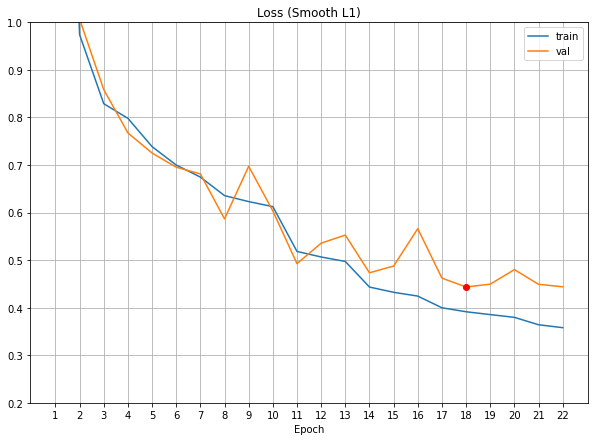

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(train_history))+1, train_history, label = 'train')
plt.plot(np.arange(len(val_history))+1, val_history, label = 'val')
plt.plot(np.arange(len(val_history))[np.argmin(val_history)]+1, np.min(val_history), 'ro')
plt.grid()
plt.title("Loss (Smooth L1)")
plt.xlabel("Epoch")
plt.legend()
plt.xticks(np.arange(len(val_history))+1)
plt.ylim([0.2,1])

In [8]:
# !curl -L https://www.dropbox.com/s/wlf9dxp543m8pqn/baseline_1_best_17.pth?dl=0 -o baseline_1_best_17.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    708      0 --:--:--  0:00:01 --:--:--     0
100  105M  100  105M    0     0  18.9M      0  0:00:05  0:00:05 --:--:-- 37.4M


In [9]:
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# loss_fn = fnn.smooth_l1_loss

with open(f"{args.name}_best_17.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)


optimizer = optim.AdamW(model.parameters(), lr=4.375e-04, amsgrad=True)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.2, 
                              patience=1, min_lr=1e-6, verbose=True)
best_val_loss = 0.4435
lr_scheduler.step(best_val_loss)


print("Ready for training with low lr...")
train_history = []
val_history = []
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    train_history.append(train_loss)
    val_history.append(val_loss)
    print("\nEpoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}".format(epoch, 
                                                     train_loss, val_loss))
    lr_scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss 
        with open(f"{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)

training...:   0%|          | 0/615 [00:00<?, ?it/s]

Ready for training with low lr...


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 0:	train loss: 0.39084	val loss: 0.44683


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 1:	train loss: 0.3846	val loss: 0.4639
Epoch     3: reducing learning rate of group 0 to 8.7500e-05.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 2:	train loss: 0.35632	val loss: 0.441


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 3:	train loss: 0.35185	val loss: 0.44516


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 4:	train loss: 0.35013	val loss: 0.44263
Epoch     6: reducing learning rate of group 0 to 1.7500e-05.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 5:	train loss: 0.34198	val loss: 0.44049


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 6:	train loss: 0.34061	val loss: 0.44094


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 7:	train loss: 0.34036	val loss: 0.4412
Epoch     9: reducing learning rate of group 0 to 3.5000e-06.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 8:	train loss: 0.33976	val loss: 0.44081


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch # 9:	train loss: 0.33824	val loss: 0.44112
Epoch    11: reducing learning rate of group 0 to 1.0000e-06.


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #10:	train loss: 0.33871	val loss: 0.44226


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #11:	train loss: 0.33778	val loss: 0.44153


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #12:	train loss: 0.3385	val loss: 0.44212


training...:   0%|          | 0/615 [00:00<?, ?it/s]


Epoch #13:	train loss: 0.3378	val loss: 0.44167


training...:   7%|▋         | 42/615 [00:45<09:36,  1.01s/it]

KeyboardInterrupt: ignored

(0.325, 0.475)

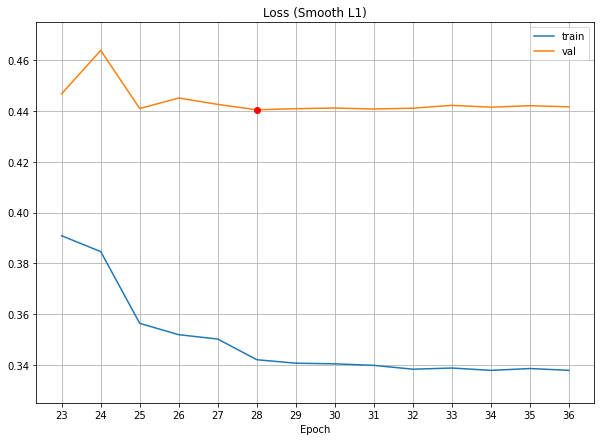

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(train_history))+23, train_history, label = 'train')
plt.plot(np.arange(len(val_history))+23, val_history, label = 'val')
plt.plot(np.arange(len(val_history))[np.argmin(val_history)]+23, np.min(val_history), 'ro')
plt.grid()
plt.title("Loss (Smooth L1)")
plt.xlabel("Epoch")
plt.legend()
plt.xticks(np.arange(len(val_history))+23)
plt.ylim([0.325,0.475])

In [ ]:
!curl -L https://www.dropbox.com/s/iqd056eltyd2sza/baseline_1_best.pth?dl=0 baseline_1_best.pth

In [15]:
# 3. predict
test_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                  shuffle=False, drop_last=False)

with open(f"{args.name}_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions = predict(model, test_dataloader, device)
with open(f"{args.name}_test_predictions.pkl", "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                  "landmarks": test_predictions}, fp)


test prediction...: 100%|██████████| 195/195 [02:35<00:00,  1.25it/s]


In [0]:
create_submission(args.data, test_predictions, f"{args.name}_adamw_resnet_50_2.csv")

**Visualize**

In [0]:
TEST_PREDICTIONS_FILENAME = "baseline_1_test_predictions.pkl"
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [0]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [19]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


In [0]:
import matplotlib.pyplot as plt
import cv2

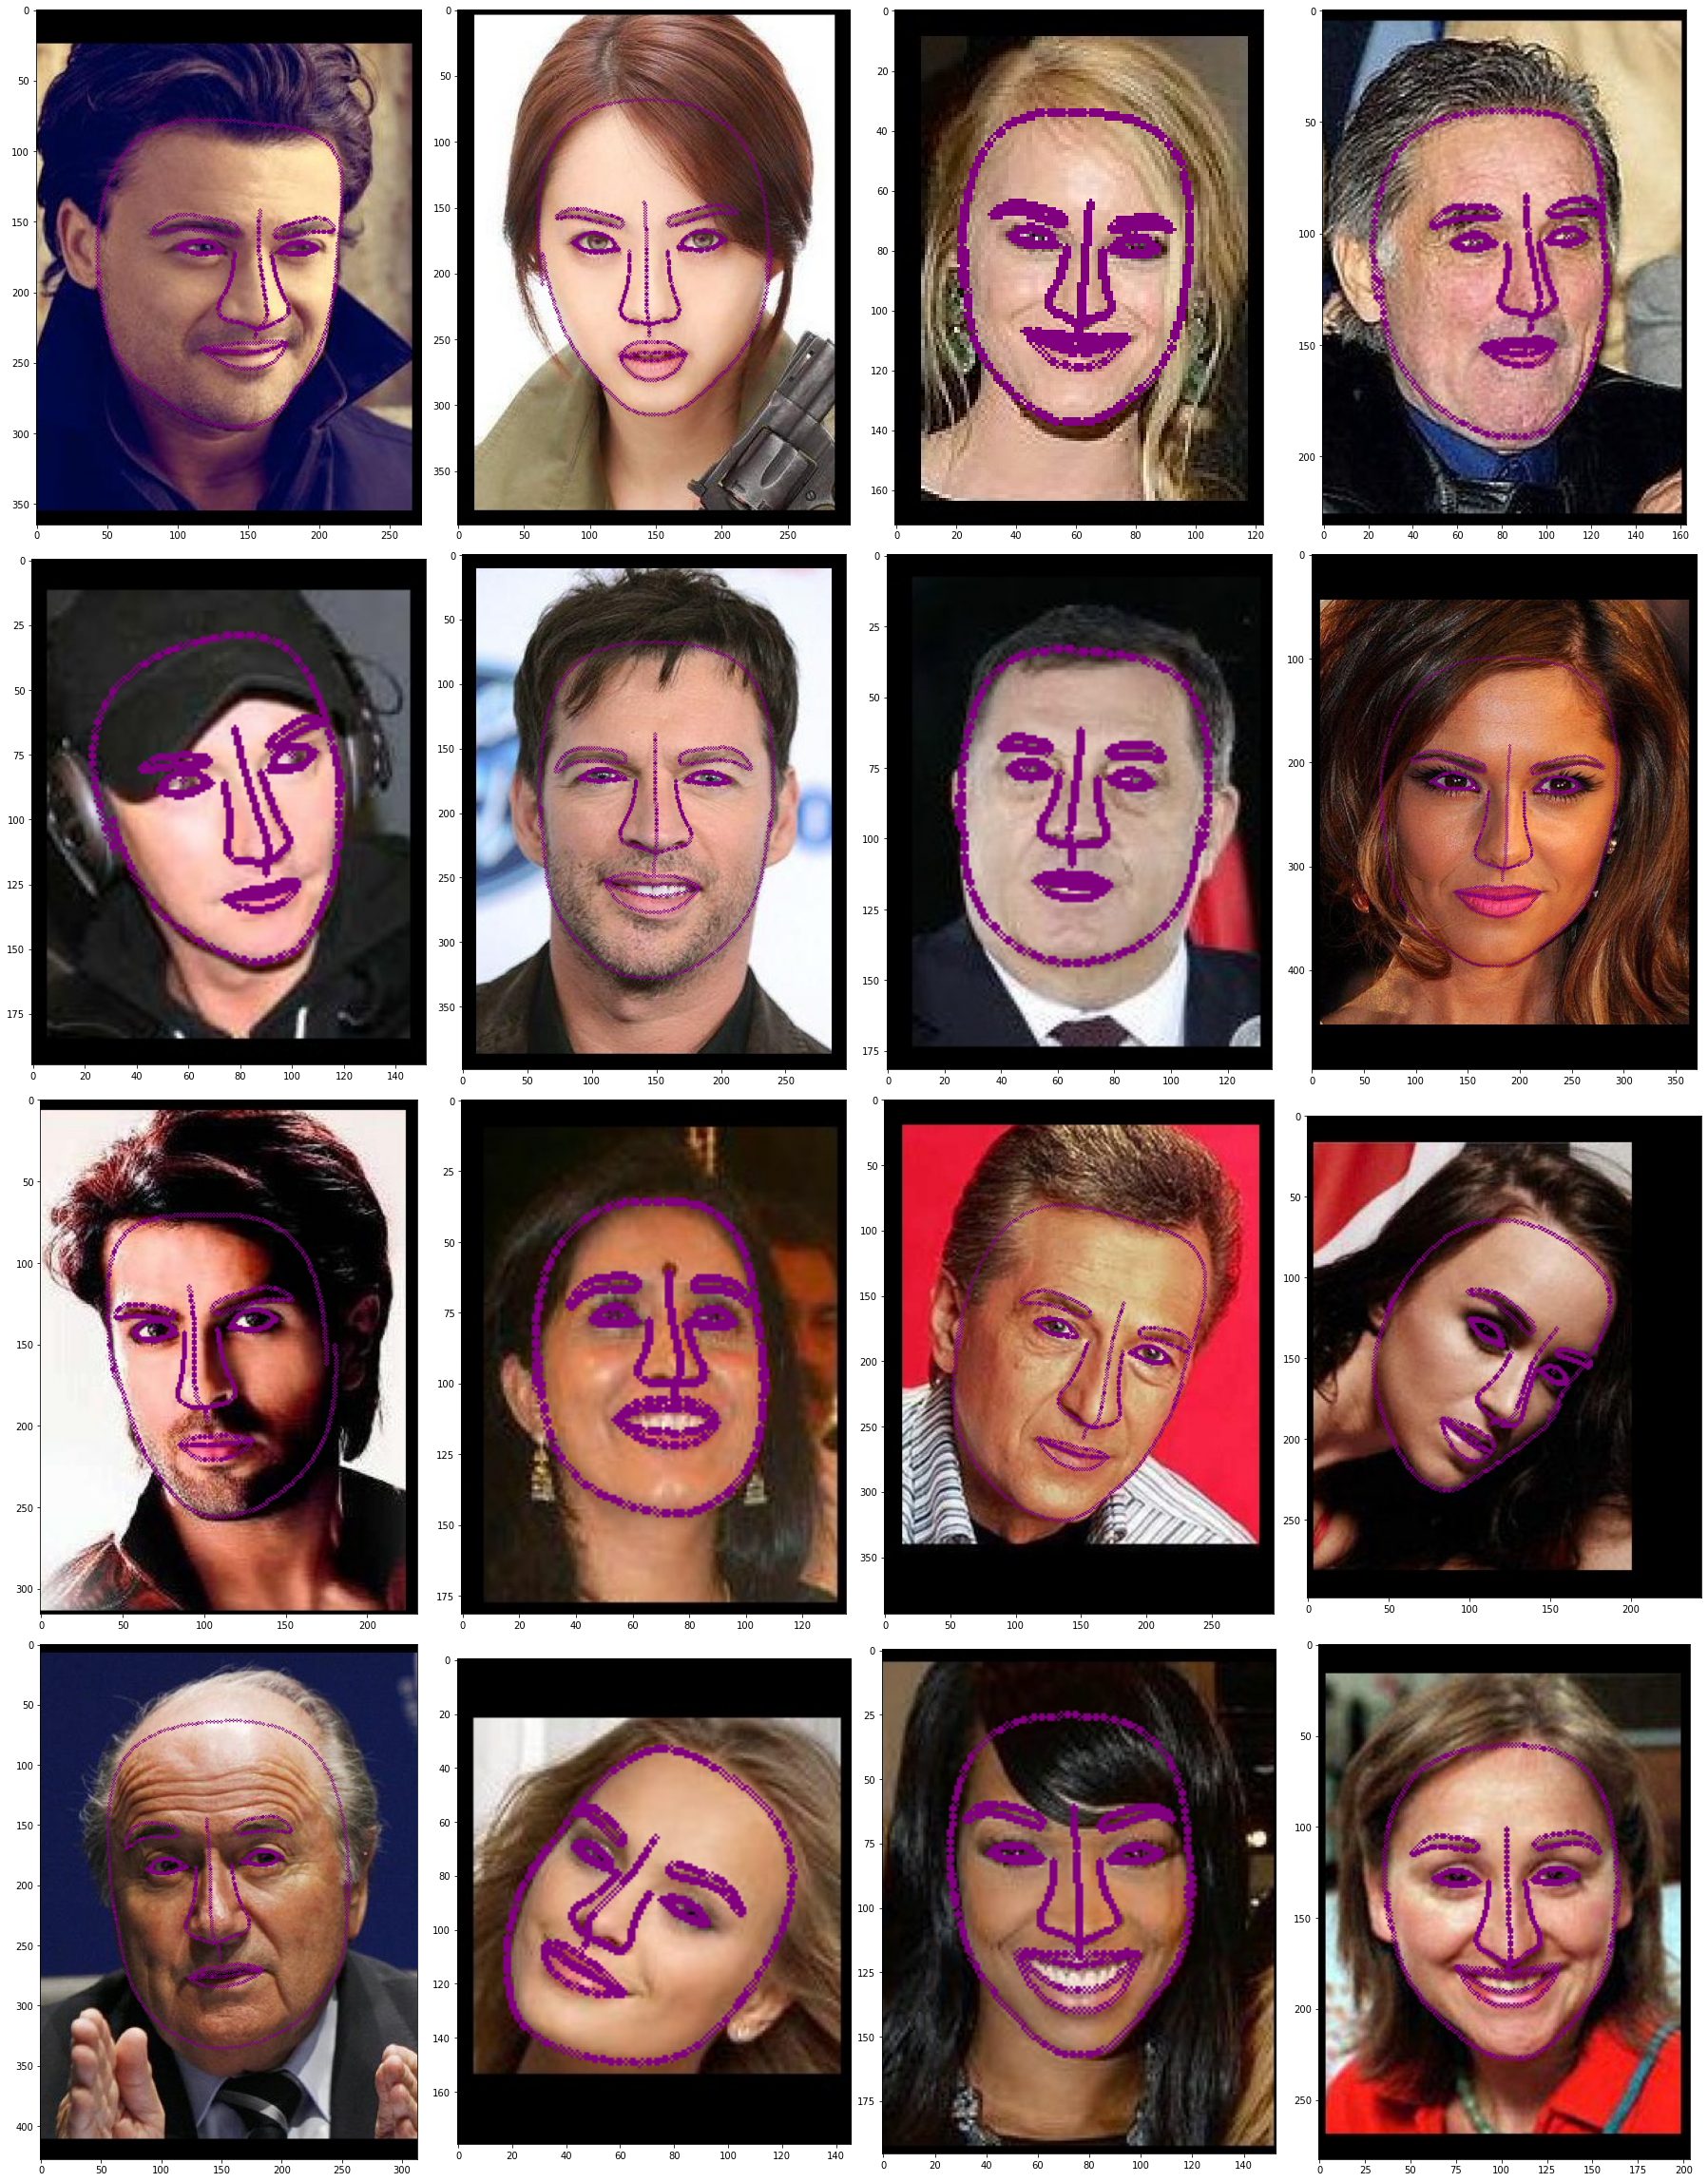

In [21]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()